## Groundnut leaf disease image classification using fine tuning

### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,  ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.metrics import categorical_crossentropy

### Preparing the Dataset

In [2]:
sdir=r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\Groundnut dataset"

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f) 
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print(df)
print (df['labels'].value_counts())

                                              filepaths           labels
0     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Early leaf spot
1     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Early leaf spot
2     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Early leaf spot
3     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Early leaf spot
4     C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...  Early leaf spot
...                                                 ...              ...
5995  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...             Rust
5996  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...             Rust
5997  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...             Rust
5998  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...             Rust
5999  C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capsto...             Rust

[6000 rows x 2 columns]
labels
Early leaf spot    1200
Healthy leaf       1200
Late leaf spot     1200
Rosette            1

### Spliting Data

In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4800   test_df length:  600   valid_df length:  600


In [4]:
# Definisikan ukuran gambar dan batch size
height = 256
width = 256
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Hitung ukuran batch untuk data pengujian
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

Test batch size: 75  Test steps: 8


### Data Preprocessing

In [5]:
# Normalisasi dan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
    

# Normalisasi data pengujian dan validasi
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Flow dari DataFrame
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 4800 validated image filenames belonging to 5 classes.


In [7]:
valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 600 validated image filenames belonging to 5 classes.


In [8]:
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 600 validated image filenames belonging to 5 classes.


In [9]:
# Daftar kelas
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

['Early leaf spot', 'Healthy leaf', 'Late leaf spot', 'Rosette', 'Rust']


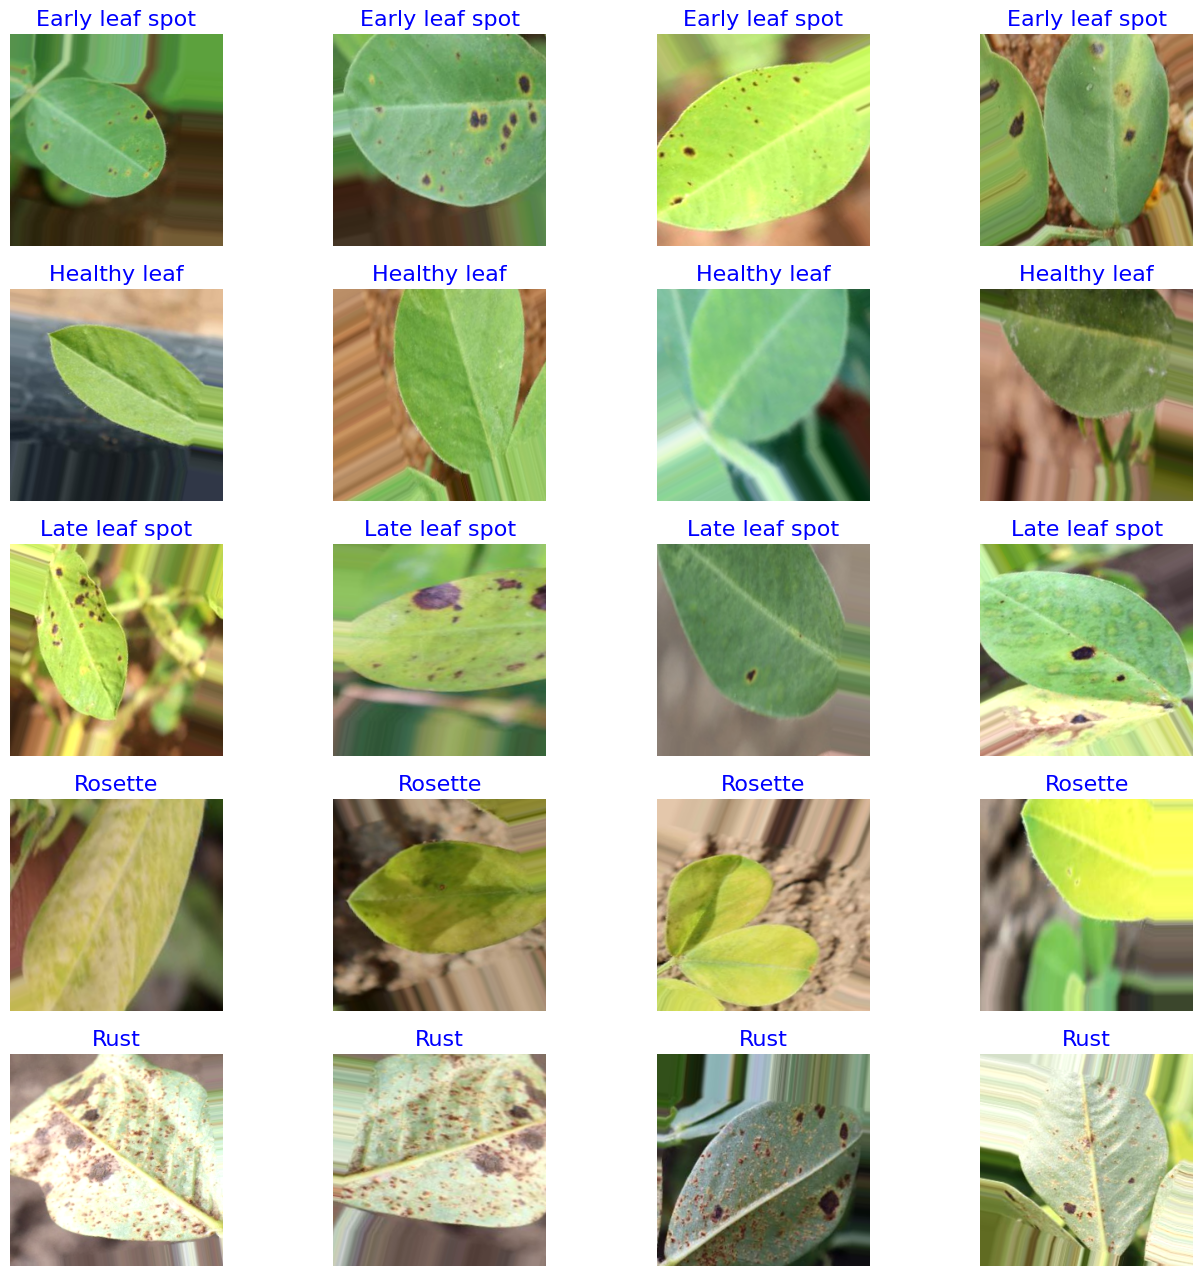

In [14]:
def show_ordered_image_samples(gen):
    # Mendapatkan daftar kelas dari generator
    test_dict = gen.class_indices
    classes = list(test_dict.keys())
    num_classes = len(classes)
    
    # Mengambil batch gambar dan label dari generator
    images, labels = next(gen)
    
    # Menyiapkan dictionary untuk mengelompokkan gambar berdasarkan kelas
    class_images = {class_name: [] for class_name in classes}
    
    # Mengelompokkan gambar berdasarkan kelas
    for i in range(len(labels)):
        index = np.argmax(labels[i])  # Mendapatkan indeks kelas dari label
        class_name = classes[index]
        class_images[class_name].append(images[i])  # Menambahkan gambar ke kelompok kelas

    # Memulai visualisasi
    plt.figure(figsize=(16, 16))
    image_count = 0

    # Menampilkan 4x4 gambar pertama sesuai urutan kelas
    for class_name in classes:
        for img in class_images[class_name][:4]:  # Mengambil 4 gambar pertama dari setiap kelas
            plt.subplot(5, 4, image_count + 1)
            plt.imshow(img)
            plt.title(class_name, color='blue', fontsize=16)
            plt.axis('off')
            image_count += 1
            
            
            if image_count >= 20:
                break
        if image_count >= 20:
            break

    plt.show()

# Panggil fungsi dengan generator data pelatihan
show_ordered_image_samples(train_gen)

### Modeling

In [15]:
base_model = tf.keras.applications.DenseNet201(
    input_tensor=Input(shape=(256,256,3)),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [16]:
for layer in base_model.layers[:-4]:  
    layer.trainable = False

In [17]:
model = Sequential([
    base_model,

    # Conv Layer 1
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name="conv1"),
    MaxPooling2D(pool_size=(2, 2), name="pool1"),

    # Conv Layer 2
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name="conv2"),
    MaxPooling2D(pool_size=(2, 2), name="pool2"),

    # Flatten layer
    Flatten(),

    # Fully connected layer 1
    Dense(256, activation='relu', name="fc1"),
    Dropout(0.5),

    # Fully connected layer 2 (output layer)
    Dense(5, activation='softmax', name="fc2")  
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 8, 8, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 8, 8, 64)       │     1,105,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,531,973 (74.51 MB)

 Trainable params: 1,250,693 (4.77 MB)

 Non-trainable params: 18,281,280 (69.74 MB)

### Training Model

In [18]:
# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memantau loss pada data validasi
    patience=3,          # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik yang dicapai selama pelatihan
)

# ReduceLROnPlateau untuk mengurangi learning rate jika val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Memantau loss pada data validasi
    factor=0.5,           # Mengurangi learning rate menjadi setengahnya jika kinerja memburuk
    patience=2,           # Jumlah epoch tanpa peningkatan sebelum learning rate dikurangi
    min_lr=1e-6,          # Batas minimal untuk learning rate
    verbose=1             # Menampilkan informasi saat learning rate dikurangi
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',                # Nama file tempat menyimpan model terbaik
    monitor='val_loss',             # Memantau val_loss untuk menentukan model terbaik
    save_best_only=True,            # Menyimpan hanya model dengan val_loss terbaik
    mode='min',                     # Jika 'min', model terbaik adalah model dengan val_loss terkecil
    verbose=1                       # Menampilkan informasi saat model disimpan
)

In [19]:
# Menyertakan callbacks saat memanggil model.fit
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

c:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5447 - loss: 1.2617 
Epoch 1: val_loss improved from inf to 0.23774, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 946s 12s/step - accuracy: 0.5470 - loss: 1.2552 - val_accuracy: 0.9067 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8919 - loss: 0.3004
Epoch 2: val_loss improved from 0.23774 to 0.14666, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 844s 11s/step - accuracy: 0.8919 - loss: 0.3003 - val_accuracy: 0.9450 - val_loss: 0.1467 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9143 - loss: 0.2371
Epoch 3: val_loss did not improve from 0.14666
75/75 ━━━━━━━━━━━━━━━━━━━━ 811s 11s/step - accuracy: 0.9143 - loss: 0.2372 - val_accuracy: 0.9267 - val_loss: 0.1757 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9322 - loss: 0.1885
Epoch 4: ReduceLROnPlateau reducing le

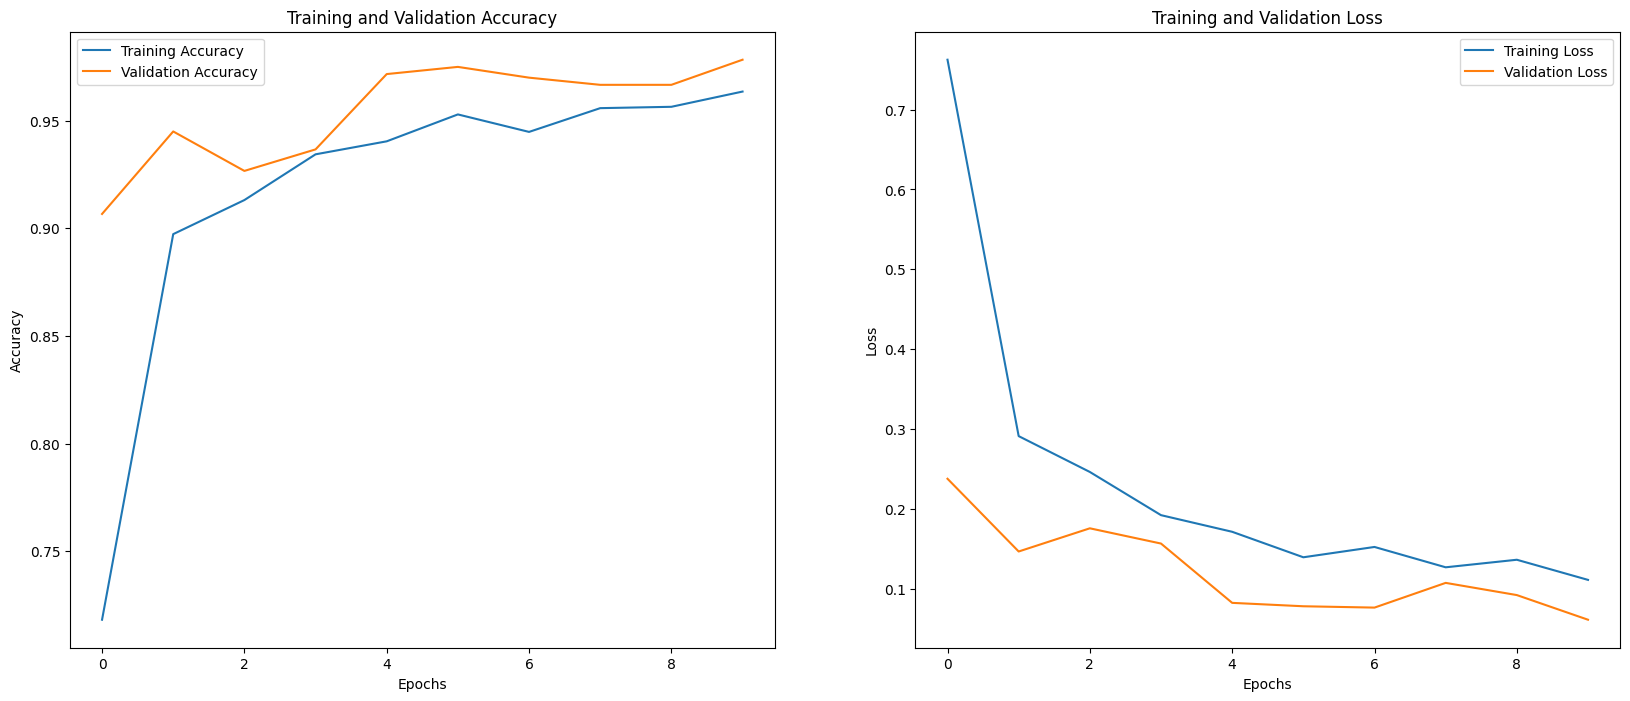

In [20]:
def plot_training_history(history):
    # Grafik Akurasi
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

### Model Evalution 

In [21]:
# Buat prediksi pada data uji
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = test_gen.classes  # Label sebenarnya

# Menghitung metrik evaluasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Jika ingin mendapatkan masing-masing nilai metrik
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 99s 11s/step
Classification Report:
                 precision    recall  f1-score   support

Early leaf spot       0.98      0.98      0.98       143
   Healthy leaf       0.98      0.98      0.98       106
 Late leaf spot       0.98      0.98      0.98       129
        Rosette       0.98      0.98      0.98       108
           Rust       1.00      1.00      1.00       114

       accuracy                           0.98       600
      macro avg       0.98      0.98      0.98       600
   weighted avg       0.98      0.98      0.98       600

F1 Score: 0.9833333333333333
Precision: 0.9833333333333333
Recall: 0.9833333333333333


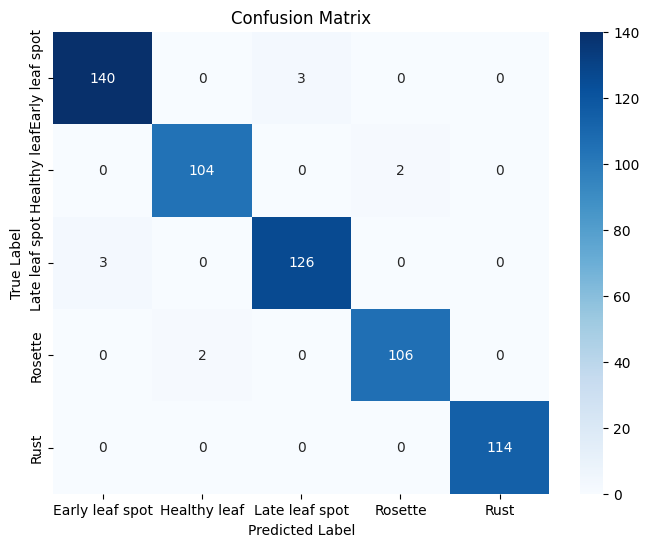

In [22]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Predict Keras model

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


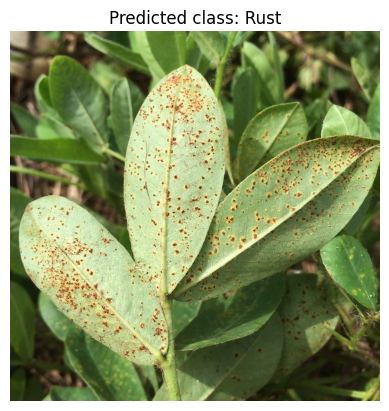

Early leaf spot: 0.0000
Healthy leaf: 0.0000
Late leaf spot: 0.0000
Rosette: 0.0000
Rust: 1.0000


In [47]:
# Path gambar
image_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\Testing\15596562766_82cb7e7083_z.jpg"

# Dimensi target gambar
height, width = 256, 256  # Ubah sesuai dengan dimensi input model Anda

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi menggunakan model
model = load_model(r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\best_model.keras")
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
predicted_probability = predictions[0][predicted_class]

# Daftar kelas

classes = ['Early leaf spot', 'Healthy leaf', 'Late leaf spot', 'Rosette', 'Rust']

# Menampilkan gambar dengan prediksi
plt.imshow(image.load_img(image_path))
plt.title(f'Predicted class: {classes[predicted_class]}')
plt.axis('off')  # Menghilangkan axis
plt.show()

for i, class_name in enumerate(classes):
    print(f'{class_name}: {predictions[0][i]:.4f}')

### Save Model to TFLite and Predict

In [48]:
# Muat model Keras
model = tf.keras.models.load_model(r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\best_model.keras")

# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Tambahkan metadata untuk preprocessing (misalnya normalisasi)
metadata = {
    "input_type": "float32",
    "normalize": "true",  # Jika model menggunakan normalisasi
    "image_size": [256, 256]  # Ukuran input model
}
converter.metadata = metadata

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan model TFLite
with open('groundnut_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmps2bmy6it\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmps2bmy6it\assets


Saved artifact at 'C:\Users\asus\AppData\Local\Temp\tmps2bmy6it'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2054468100432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468099088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468094288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468098896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468099664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468096976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468096208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468099472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468093520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2054468098128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20544

Input shape yang diharapkan oleh model: [  1 256 256   3]


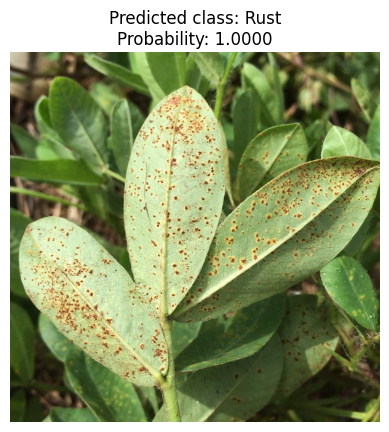

Early leaf spot: 0.0000
Healthy leaf: 0.0000
Late leaf spot: 0.0000
Rosette: 0.0000
Rust: 1.0000


In [64]:
# Path gambar
image_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\Testing\Rust3.jpg"

# Dimensi target gambar
height, width = 256, 256  

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

# Normalisasi gambar 
img_array /= 255.0  

# Muat model TensorFlow Lite
tflite_model_path = r"C:\Users\asus\Bayu\Kuliah\SMT 7\Bangkit\Capstone\capstone_env\Groundnut\groundnut_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Mendapatkan informasi tentang tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Memeriksa bentuk input tensor yang diharapkan
input_shape = input_details[0]['shape']  
print(f"Input shape yang diharapkan oleh model: {input_shape}")

# Memastikan input tensor sesuai dengan model
input_data = np.array(img_array, dtype=np.float32)  # Pastikan tipe data sesuai

# Set tensor input
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil prediksi
output_data = interpreter.get_tensor(output_details[0]['index'])
predictions = output_data[0]

# Menentukan kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions)
predicted_probability = predictions[predicted_class]  # Probabilitas kelas yang diprediksi

# Daftar kelas
classes = ['Early leaf spot', 'Healthy leaf', 'Late leaf spot', 'Rosette', 'Rust']

# Menampilkan gambar dengan prediksi dan probabilitas
plt.imshow(image.load_img(image_path))
plt.title(f'Predicted class: {classes[predicted_class]}\nProbability: {predicted_probability:.4f}')
plt.axis('off')  
plt.show()

# Menampilkan semua probabilitas untuk setiap kelas
for i, class_name in enumerate(classes):
    print(f'{class_name}: {predictions[i]:.4f}')
